# 🏥 ArogyaMitra — Disease Prediction from Symptoms
**Model:** Random Forest + XGBoost → Pick Best → Explain with LIME

### Dataset Setup
Place all 4 CSV files in `ML-Model/dataset/`:
- `dataset.csv` — main training data
- `Symptom-severity.csv` — symptom severity weights
- `symptom_Description.csv` — disease descriptions
- `symptom_precaution.csv` — disease precautions

In [1]:
!pip install pandas numpy scikit-learn xgboost lime matplotlib seaborn joblib

  Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached xgboost-3.2.0-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached lime-0.2.0.1-py3-none-any.whl
  Using cached matplotlib-3.10.8-cp312-cp312-win_amd64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.17.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached tqdm-4.67.3-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached packaging-26.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pillow-12.1.1-cp312-cp312-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached networkx-3.6.1-py3-none-a

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-client 1.13.1 requires pyyaml>=3.12, which is not installed.
anaconda-project 0.11.1 requires jinja2, which is not installed.
astropy 6.1.3 requires PyYAML>=3.13, which is not installed.
bokeh 3.6.0 requires Jinja2>=2.9, which is not installed.
bokeh 3.6.0 requires PyYAML>=3.10, which is not installed.
conda-build 24.9.0 requires beautifulsoup4, which is not installed.
conda-build 24.9.0 requires filelock, which is not installed.
conda-build 24.9.0 requires jinja2, which is not installed.
conda-build 24.9.0 requires psutil, which is not installed.
conda-build 24.9.0 requires pyyaml, which is not installed.
conda-index 0.5.0 requires filelock, which is not installed.
conda-index 0.5.0 requires jinja2, which is not installed.
cookiecutter 2.6.0 requires Jinja2<4.0.0,>=2.7, which is not installed.
cookiecutt

## 1 — Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import lime
import lime.lime_tabular

# In Jupyter, os.getcwd() gives us where the kernel started
CWD = os.getcwd()
print(f'Current working dir: {CWD}')

if os.path.basename(CWD) == 'notebook':
    BASE_DIR = os.path.dirname(CWD)
else:
    BASE_DIR = CWD

DATASET_PATH = os.path.join(BASE_DIR, 'dataset') + os.sep
MODEL_PATH   = os.path.join(BASE_DIR, 'model') + os.sep
os.makedirs(MODEL_PATH, exist_ok=True)

print(f'Dataset path: {DATASET_PATH}')
print(f'Model path  : {MODEL_PATH}')
print('✅ Ready')

Current working dir: d:\Coding\Techathon-3.0\ML-Model
Dataset path: d:\Coding\Techathon-3.0\ML-Model\dataset\
Model path  : d:\Coding\Techathon-3.0\ML-Model\model\
✅ Ready


## 2 — Load All Datasets

In [12]:
# Main training data
df = pd.read_csv(DATASET_PATH + 'dataset.csv').fillna(0)

# Symptom severity (1-7 scale)
severity_df = pd.read_csv(DATASET_PATH + 'Symptom-severity.csv')
severity_df.columns = severity_df.columns.str.strip()
severity_map = dict(zip(
    severity_df['Symptom'].str.strip().str.lower().str.replace(' ', '_'),
    severity_df['weight']
))

# Disease descriptions
desc_df = pd.read_csv(DATASET_PATH + 'symptom_Description.csv')
desc_df.columns = desc_df.columns.str.strip()
description_map = dict(zip(desc_df['Disease'].str.strip(), desc_df['Description'].str.strip()))

# Precautions
prec_df = pd.read_csv(DATASET_PATH + 'symptom_precaution.csv')
prec_df.columns = prec_df.columns.str.strip()
precaution_map = {}
for _, row in prec_df.iterrows():
    disease = str(row['Disease']).strip()
    precautions = [str(row[f'Precaution_{i}']).strip() for i in range(1, 5)
                   if pd.notna(row[f'Precaution_{i}']) and str(row[f'Precaution_{i}']).strip() != 'nan']
    precaution_map[disease] = precautions

print(f'Training records  : {len(df)}')
print(f'Severity entries  : {len(severity_map)}')
print(f'Disease descriptions: {len(description_map)}')
print(f'Disease precautions : {len(precaution_map)}')

Training records  : 4920
Severity entries  : 132
Disease descriptions: 41
Disease precautions : 41


## 3 — Preprocessing

In [15]:
# The dataset has columns: Disease, Symptom_1, Symptom_2, ... Symptom_17
# We need to one-hot encode them into a binary matrix

# Get all unique symptoms across all symptom columns
symptom_cols_raw = [c for c in df.columns if 'Symptom' in c]
all_symptoms = set()
for col in symptom_cols_raw:
    df[col] = df[col].str.strip().str.lower().str.replace(' ', '_')
    all_symptoms.update(df[col].dropna().unique())

all_symptoms = sorted([s for s in all_symptoms if s and s != '0' and s != 'nan'])
print(f'Unique symptoms found: {len(all_symptoms)}')

# Build binary feature matrix
X = pd.DataFrame(0, index=df.index, columns=all_symptoms)
for col in symptom_cols_raw:
    for symptom in all_symptoms:
        X.loc[df[col] == symptom, symptom] = 1

symptom_columns = list(X.columns)

# Encode target
le = LabelEncoder()
y = le.fit_transform(df['Disease'])
disease_classes = list(le.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Symptoms (features): {len(symptom_columns)}')
print(f'Diseases (classes) : {len(disease_classes)}')
print(f'Train: {len(X_train)} | Test: {len(X_test)}')

Unique symptoms found: 131
Symptoms (features): 131
Diseases (classes) : 41
Train: 3936 | Test: 984


## 4 — Train Random Forest

In [16]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))
rf_cv  = cross_val_score(rf_model, X, y, cv=5).mean()
print(f'Random Forest → Test: {rf_acc*100:.2f}%  CV: {rf_cv*100:.2f}%')

Random Forest → Test: 100.00%  CV: 100.00%


## 5 — Train XGBoost

In [17]:
xgb_model = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    random_state=42, eval_metric='mlogloss', use_label_encoder=False
)
xgb_model.fit(X_train, y_train)
xgb_acc = accuracy_score(y_test, xgb_model.predict(X_test))
xgb_cv  = cross_val_score(xgb_model, X, y, cv=5).mean()
print(f'XGBoost       → Test: {xgb_acc*100:.2f}%  CV: {xgb_cv*100:.2f}%')

XGBoost       → Test: 100.00%  CV: 100.00%


## 6 — Model Comparison Chart

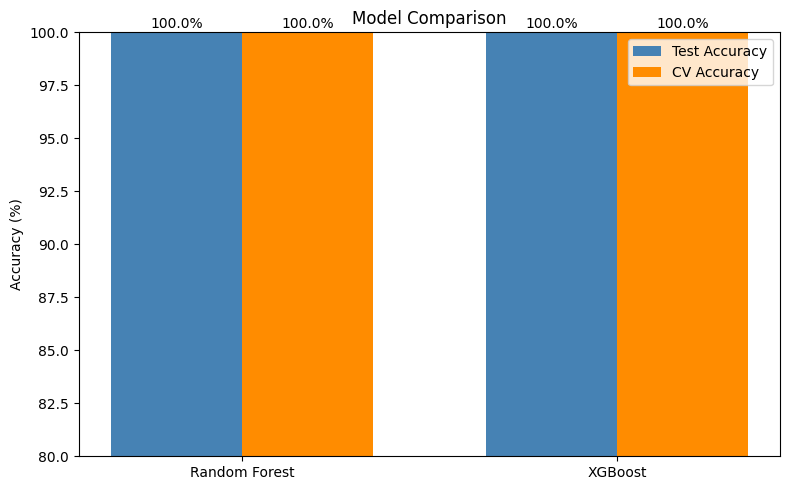


🏆 Winner: Random Forest (100.00%)


In [18]:
labels = ['Random Forest', 'XGBoost']
test_accs = [rf_acc*100, xgb_acc*100]
cv_accs   = [rf_cv*100, xgb_cv*100]
x = np.arange(2)
w = 0.35

fig, ax = plt.subplots(figsize=(8,5))
b1 = ax.bar(x-w/2, test_accs, w, label='Test Accuracy', color='steelblue')
b2 = ax.bar(x+w/2, cv_accs,   w, label='CV Accuracy',   color='darkorange')
ax.set_ylabel('Accuracy (%)'); ax.set_title('Model Comparison')
ax.set_xticks(x); ax.set_xticklabels(labels); ax.legend(); ax.set_ylim(80,100)
for bar in list(b1)+list(b2):
    ax.annotate(f'{bar.get_height():.1f}%',
                xy=(bar.get_x()+bar.get_width()/2, bar.get_height()),
                xytext=(0,3), textcoords='offset points', ha='center')
plt.tight_layout()
plt.savefig(MODEL_PATH+'model_comparison.png', dpi=150)
plt.show()

best_model      = rf_model  if rf_acc >= xgb_acc else xgb_model
best_model_name = 'Random Forest' if rf_acc >= xgb_acc else 'XGBoost'
best_acc        = max(rf_acc, xgb_acc)
print(f'\n🏆 Winner: {best_model_name} ({best_acc*100:.2f}%)')

## 7 — LIME Explainer

In [20]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=symptom_columns,
    class_names=disease_classes,
    mode='classification',
    random_state=42
)

# Demo explanation
sample = X_test.iloc[0].values
exp = explainer.explain_instance(sample, best_model.predict_proba, num_features=10)
pred  = disease_classes[best_model.predict([sample])[0]]
actual = disease_classes[y_test[0]]
print(f'Actual: {actual}  |  Predicted: {pred}')
for feat, w in exp.as_list():
    print(f'  {"✅" if w>0 else "❌"} {feat}: {w:.4f}')

Actual: Hypertension   |  Predicted: Hypertension 
  ❌ patches_in_throat <= 0.00: -0.1910
  ❌ muscle_wasting <= 0.00: -0.1873
  ❌ extra_marital_contacts <= 0.00: -0.1427
  ❌ high_fever <= 0.00: -0.0376
  ✅ muscle_pain <= 0.00: 0.0135
  ✅ family_history <= 0.00: 0.0124
  ✅ unsteadiness <= 0.00: 0.0123
  ❌ lack_of_concentration > 0.00: -0.0121
  ✅ blister <= 0.00: 0.0121
  ✅ skin_peeling <= 0.00: 0.0106


## 8 — Predict Function (used by FastAPI)

In [21]:
def predict_disease(symptoms_list, patient_name='Patient', patient_age=None, patient_gender=None, top_n=3):
    """
    Returns a full structured result including predictions, LIME, descriptions, and precautions.
    This dict is used by FastAPI to generate the PDF report.
    """
    input_vector = np.zeros(len(symptom_columns))
    matched, unmatched = [], []
    symptom_severities = []

    for s in symptoms_list:
        s_clean = s.strip().lower().replace(' ', '_')
        if s_clean in symptom_columns:
            input_vector[symptom_columns.index(s_clean)] = 1
            matched.append(s_clean)
            symptom_severities.append({'symptom': s_clean, 'severity': severity_map.get(s_clean, 1)})
        else:
            unmatched.append(s)

    # Predictions
    proba = best_model.predict_proba([input_vector])[0]
    top_idx = np.argsort(proba)[::-1][:top_n]
    top_disease = disease_classes[top_idx[0]]
    confidence  = round(float(proba[top_idx[0]]) * 100, 2)

    predictions = [
        {'disease': disease_classes[i], 'confidence': round(float(proba[i])*100, 2)}
        for i in top_idx
    ]

    # LIME
    exp = explainer.explain_instance(input_vector, best_model.predict_proba, num_features=10)
    lime_reasons = [
        {'feature': feat, 'impact': round(w, 4), 'direction': 'supports' if w > 0 else 'against'}
        for feat, w in exp.as_list()
    ]

    # Overall severity score
    avg_severity = round(np.mean([s['severity'] for s in symptom_severities]), 2) if symptom_severities else 0

    return {
        'patientInfo': {
            'name': patient_name,
            'age': patient_age,
            'gender': patient_gender
        },
        'primaryDiagnosis': top_disease,
        'confidenceScore': confidence,
        'severityScore': avg_severity,
        'topPredictions': predictions,
        'matchedSymptoms': matched,
        'unmatchedSymptoms': unmatched,
        'symptomSeverities': symptom_severities,
        'diseaseDescription': description_map.get(top_disease, 'No description available.'),
        'precautions': precaution_map.get(top_disease, []),
        'limeExplanation': lime_reasons,
        'modelUsed': best_model_name,
        'modelAccuracy': round(best_acc * 100, 2)
    }

# Test
result = predict_disease(
    symptoms_list=['fever', 'chills', 'headache', 'sweating'],
    patient_name='Ayush', patient_age=22, patient_gender='male'
)
print(json.dumps(result, indent=2))

{
  "patientInfo": {
    "name": "Ayush",
    "age": 22,
    "gender": "male"
  },
  "primaryDiagnosis": "Heart attack",
  "confidenceScore": 24.0,
  "severityScore": 3.0,
  "topPredictions": [
    {
      "disease": "Heart attack",
      "confidence": 24.0
    },
    {
      "disease": "Allergy",
      "confidence": 23.0
    },
    {
      "disease": "Malaria",
      "confidence": 18.5
    }
  ],
  "matchedSymptoms": [
    "chills",
    "headache",
    "sweating"
  ],
  "unmatchedSymptoms": [
    "fever"
  ],
  "symptomSeverities": [
    {
      "symptom": "chills",
      "severity": 3
    },
    {
      "symptom": "headache",
      "severity": 3
    },
    {
      "symptom": "sweating",
      "severity": 3
    }
  ],
  "diseaseDescription": "The death of heart muscle due to the loss of blood supply. The loss of blood supply is usually caused by a complete blockage of a coronary artery, one of the arteries that supplies blood to the heart muscle.",
  "precautions": [
    "call ambulan

## 9 — Save Artifacts

In [23]:
joblib.dump(best_model,              MODEL_PATH + 'disease_model.pkl')
joblib.dump(le,                      MODEL_PATH + 'label_encoder.pkl')
joblib.dump(symptom_columns,         MODEL_PATH + 'symptom_columns.pkl')
joblib.dump(np.array(X_train),       MODEL_PATH + 'X_train.pkl')   # ← instead of lime_explainer
joblib.dump(severity_map,            MODEL_PATH + 'severity_map.pkl')
joblib.dump(description_map,         MODEL_PATH + 'description_map.pkl')
joblib.dump(precaution_map,          MODEL_PATH + 'precaution_map.pkl')

metadata = {
    'best_model': best_model_name,
    'accuracy': round(best_acc*100, 2),
    'rf_accuracy': round(rf_acc*100, 2),
    'xgb_accuracy': round(xgb_acc*100, 2),
    'total_diseases': len(disease_classes),
    'total_symptoms': len(symptom_columns),
    'diseases': disease_classes,
    'symptoms': symptom_columns
}
with open(MODEL_PATH + 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print('✅ All artifacts saved to ../model/')
for f in os.listdir(MODEL_PATH):
    print(f'   {f}')

✅ All artifacts saved to ../model/
   description_map.pkl
   disease_model.pkl
   label_encoder.pkl
   lime_explainer.pkl
   metadata.json
   model_comparison.png
   precaution_map.pkl
   severity_map.pkl
   symptom_columns.pkl
   X_train.pkl
